In [1]:
#Evaluate ACCESS-OM2-01 IAF Properties in Denman Region
#https://cchdo.ucsd.edu/search?bbox=105,-90,115,-50

In [32]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pyproj import Proj, transform

In [3]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:36187 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


In [80]:
bedbathy=xr.open_mfdataset('/g/data/v45/pas561/bedmachineant/BedMach*.nc',engine='netcdf4',decode_times=False)
bedbathy

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    bed        (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

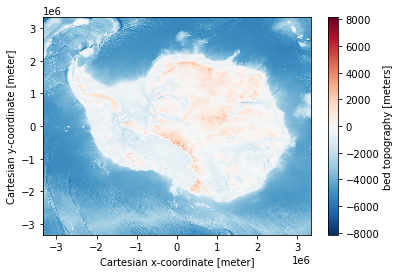

In [62]:
bedbathy.bed.plot.pcolormesh()

In [78]:
#need to convert from funny GIS coordinates to lat/lon
#https://gis.stackexchange.com/questions/78838/converting-projected-coordinates-to-lat-lon-using-python
#min and max values are weird for x ... doesn't work ... range of -45 to 135
inProj = Proj(init='epsg:3031')
outProj = Proj(init='epsg:4326')

x2,y2 = transform(inProj,outProj,bedbathy.x.values,bedbathy.y.values)
print(x2,y2)
print(np.min(x2),np.max(x2),np.min(y2),np.max(y2))

[-45. -45. -45. ... 135. 135. 135.] [-48.46438311 -48.47009947 -48.47581604 ... -48.47581604 -48.47009947
 -48.46438311]
-45.0 135.0 -90.0 -48.464383106398614


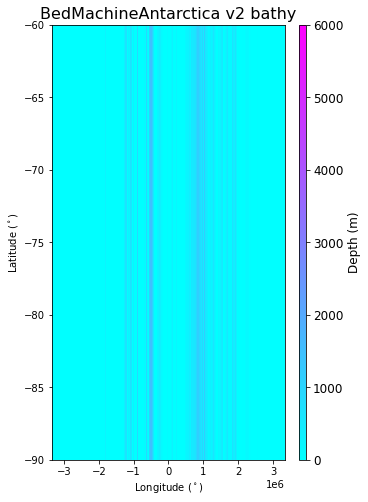

In [76]:
#np.nanmax(ht.values)
clev = np.arange(0,6000,10)
clev2 = np.arange(0,6000,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
p1=plt.pcolormesh(bedbathy.x,bedbathy.y,bedbathy.bed,vmin=0, vmax=6000,cmap=plt.cm.cool)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-90,-60])
#plt.xlim([-270,-250])
plt.title('BedMachineAntarctica v2 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


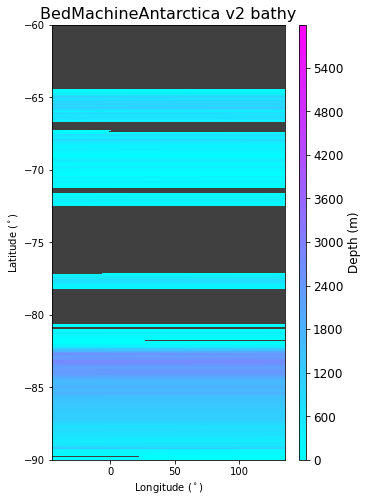

In [79]:
#plot using new lat lon coords .... stalls out
clev = np.arange(0,6000,10)
clev2 = np.arange(0,6000,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(x2,y2,bedbathy.bed,levels=clev,cmap=plt.cm.cool)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-90,-60])
#plt.xlim([-270,-250])
plt.title('BedMachineAntarctica v2 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

#Plot ACCCESS-OM2-01 model bathymetry

In [68]:

# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [69]:
# topography data for plotting:
lat_slice  = slice(-82,-50.04) #-50.04-

ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [70]:
np.nanmax(ht.values)

5808.6567

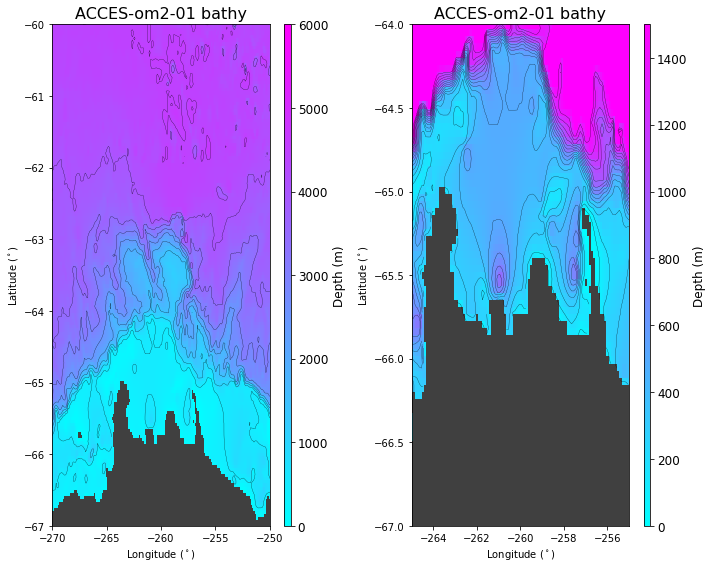

In [75]:
#np.nanmax(ht.values)
clev = np.arange(0,6000,10)
clev2 = np.arange(0,6000,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-60])
plt.xlim([-270,-250])
plt.title('ACCES-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

clev = np.arange(0,1500,5)
clev2 = np.arange(0,1500,100)

plt.subplot(1,2,2)
plt.gca().patch.set_color('.25')
p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-64])
plt.xlim([-265,-255])
plt.title('ACCES-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()